## Reference

- [Simple dynamic seq2seq with TensorFlow](https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/1-seq2seq.ipynb)

In [1]:
import tensorflow as tf
import numpy as np

## Utils

In [2]:
def gen_batch(inputs, max_sequence_length=None):
    sequence_lengths =[len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
        
    # 0 == PAD
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32) 
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element
            
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)
    return inputs_time_major, sequence_lengths

## Vocabulary

In [3]:
x = [
    [5, 7, 8],
    [6, 3],
    [3],
    [1]
]

xt, xlen = gen_batch(x)
xt

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]], dtype=int32)

In [4]:
xlen

[3, 2, 1, 1]

## Building a model - Simple Seq2Seq

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [6]:
# Model inputs and outputs

PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_utits = encoder_hidden_units

In [7]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [8]:
# Embeddings

embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0),
                         dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [9]:
# Encoder

encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded, dtype=tf.float32, time_major=True
)

del encoder_outputs  # seq2seq do not need this.

In [10]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [11]:
# Decoder

decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_utits)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded, initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True, scope="plain_decoder"
)

decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits, 2)

decoder_logits

<tf.Tensor 'fully_connected/Reshape_1:0' shape=(?, ?, 10) dtype=float32>

In [12]:
# Optimizer

stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

sess.run(tf.global_variables_initializer())

In [13]:
# Test forward pass

batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = gen_batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = gen_batch(np.ones(shape=(3, 1), dtype=np.int32),max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[1 9 5]
 [6 6 6]
 [6 6 6]
 [6 6 6]]


In [14]:
# Training on the toy task

# We will teach our model to memorize and reproduce input sequence. 
# Sequences will be random, with varying length.

batch_size = 100

def random_sequences(length_from, length_to, vocab_lower, vocab_upper, batch_size):
    if length_from > length_to:
        raise ValueError('length_from > length_to')
        
    def random_length():
        if length_from == length_to:
            return length_from
        return np.random.randint(length_from, length_to+1)

    while True:
        yield [
            np.random.randint(low=vocab_lower, high=vocab_upper, size=random_length()).tolist()
            for _ in range(batch_size)
        ]
        
batches = random_sequences(3, 8, 2, 10, batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[6, 2, 5, 5, 6, 4, 9]
[3, 4, 2, 6]
[7, 3, 9, 4, 4, 3, 8, 7]
[6, 4, 8, 4, 4, 6]
[9, 4, 7, 3, 7, 2, 8, 2]
[4, 9, 8, 4, 2, 4]
[8, 5, 4, 9, 9, 3]
[6, 4, 5]
[5, 4, 8, 7, 9]
[3, 2, 8, 4]


In [15]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = gen_batch(batch)
    decoder_targets_, _ = gen_batch([(sequence) + [EOS] for sequence in batch])
    decoder_inputs_, _ = gen_batch([[EOS] + (sequence) for sequence in batch])
    
    return {
        encoder_inputs: encoder_inputs_,
        decoder_targets: decoder_targets_,
        decoder_inputs: decoder_inputs_
    }

In [16]:
loss_track = []

max_batches = 3001
batches_in_epoch = 1000

for batch in range(max_batches):
    fd = next_feed()
    _, l = sess.run([train_op, loss], fd)
    loss_track.append(l)
    
    # Verbose
    if batch == 0 or batch % batches_in_epoch == 0:
        print('batch {}'.format(batch))
        print('  minibatch loss: {}'.format(sess.run(loss, fd)))
        predict_ = sess.run(decoder_prediction, fd)
        for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
            print('  sample {}:'.format(i + 1))
            print('    input     > {}'.format(inp))
            print('    predicted > {}'.format(pred))
            if i >= 2:
                break
        print('--------------------------')

batch 0
  minibatch loss: 2.2975735664367676
  sample 1:
    input     > [4 2 3 8 4 0 0 0]
    predicted > [9 0 0 5 0 0 6 6 6]
  sample 2:
    input     > [9 9 4 0 0 0 0 0]
    predicted > [4 0 3 7 6 6 6 6 6]
  sample 3:
    input     > [9 2 2 7 0 0 0 0]
    predicted > [4 0 3 3 9 0 6 6 6]
--------------------------
batch 1000
  minibatch loss: 0.30719828605651855
  sample 1:
    input     > [2 9 9 7 9 0 0 0]
    predicted > [9 9 9 7 9 1 0 0 0]
  sample 2:
    input     > [7 8 4 0 0 0 0 0]
    predicted > [7 8 4 1 0 0 0 0 0]
  sample 3:
    input     > [8 4 6 0 0 0 0 0]
    predicted > [8 4 6 1 0 0 0 0 0]
--------------------------
batch 2000
  minibatch loss: 0.13718031346797943
  sample 1:
    input     > [3 2 5 9 6 8 9 0]
    predicted > [3 2 5 9 6 8 9 1 0]
  sample 2:
    input     > [4 5 2 6 3 4 0 0]
    predicted > [4 5 2 6 3 4 1 0 0]
  sample 3:
    input     > [8 3 9 4 0 0 0 0]
    predicted > [8 3 9 4 1 0 0 0 0]
--------------------------
batch 3000
  minibatch loss: 0.0886909

loss 0.0971 after 300100 examples (batch_size=100)


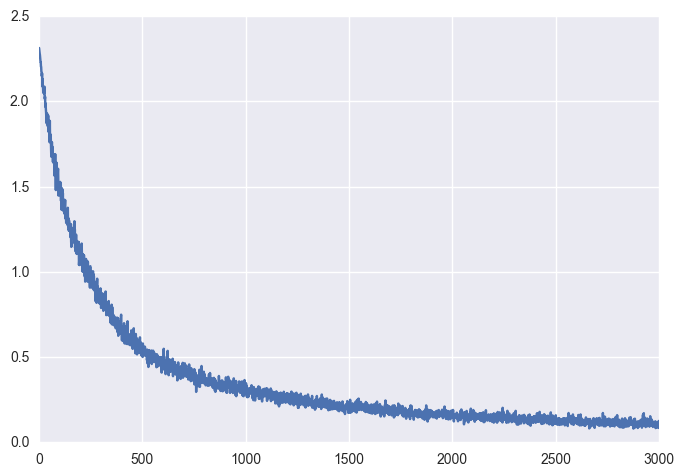

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn; seaborn.set()

plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))